### Problem of Interest
Find $u(x,t)$ that satisfies $\\$
$\begin{cases} u_t = 4u_{xx} \text{ for all } 0 \leq x \leq 1, 0 \leq t \leq 1 \\ u(x,0) = e^{-x/2} \text{ for all } 0 \leq x \leq 1 \\ u(0,t) = e^t \text{ for all } 0 \leq t \leq 1 \\ u(1,t) = e^{t-1/2} \text{ for all } 0 \leq t \leq 1 \end{cases} \\$

### Overview

Some of the functions in the code from an internal library of functions - a function to create tr-diagonal matrices to use in the finite difference methods and a conjugate gradient function to solve systems in the backward method. We'll use both the backward and forward difference methods on the problem of interest and investigate the forward error at each time step to analyze the convergence rates of the methods. 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from internallib import CG, tridiag
plt.rcParams['font.size'] = 16

In [18]:
def bw_FDM(w, par):
    """
    Return the next time iterate of the heat equation using backward difference method.
    
    Input:
        w: (1D array) Temperature distribution at time t.
        par: (dict) Parameter for the forward difference method.
    Output:
        w_new: (1D array) Temperature distribution at time t+1.
    """
    # extract parameters
    s = par['D']*par['k']/(par['h']*par['h'])
    bc1 = par['bc1']
    bc2 = par['bc2']

    w_new = np.zeros_like(w[1:-1])
    b = w[1:-1].copy()
    b[0] += s*bc1
    b[-1] += s*bc2

    # Construct the matrix A
    A = tridiag(-s, 1+2*s, -s, len(b))

    # Main line of the backward difference method
    w_new, _ = CG(A, b, w[1:-1])
    """
    This line is equivalent to the following for loop, but much faster.
    N = len(w)
    for i in range(1, N+1):
        w_new[i] = w[i] + s*(w[i-1] - 2*w[i] + w[i+1])
    """

    return w_new

In [19]:
def fw_FDM(w, par):
    """
    Return the next time of the heat equation using forward difference method.
    
    Input:
        w: (1D array) Temperature distribution at time t.
        par: (dict) Parameter for the forward difference method.
    Output:
        w_new: (1D array) Temperature distribution at time t+1.
    """
    s = par['D']*par['k']/(par['h']*par['h'])

    w_new = np.zeros_like(w[1:-1])

    # Main line of the forward difference method
    w_new = w[1:-1] + s*(w[2:] - 2.*w[1:-1] + w[:-2])
    """
    This line is equivalent to the following for loop, but much faster.
    N = len(w)
    for i in range(1, N+1):
        w_new[i] = w[i] + s*(w[i-1] - 2*w[i] + w[i+1])
    """

    return w_new

In [20]:
def solve_heat_eq(ic, bc1, bc2, D, a, b, T, N, K, t0=0., method='backward'):
    """
    Return numerical solution of Heat equation using backward difference method.
    
    Input:
        ic: (1D array) Initial temperature distribution.
        bc1: (float or 1D array) Boundary condition at x=a. Constant boundary condition is assumed.
        bc2: (float or 1D array) Boundary condition at x=b. Constant boundary condition is assumed.
        D: (float) Diffusion coefficient.
        a: (float) Left boundary.
        b: (float) Right boundary.
        T: (float) Final time.
        N: (int) Number of spatial grid points.
        K: (int) Number of time grid points.
        t0: (float) Initial time. (default=0.)
        method: (str) 'forward' or 'backward'. (default='backward')
    Output:
        w: (2D array) Numerical solution.
    """
    w = np.zeros((N+2, K+1))
    h = (b-a)/(N+1)
    k = (T-t0)/K
    #par = {'D': D, 'h': h, 'k': k, 'bc1': bc1, 'bc2': bc2}

    # Initial/boundary condition
    w[:, 0] = ic
    w[0, :] = bc1
    w[-1, :] = bc2

    # time marching
    if method == 'forward':
        for j in range(K):
            par = {'D': D,
                   'h': h, 
                   'k': k, 
                   'bc1': bc1[j], 
                   'bc2': bc2[j]}
            w[1:-1, j+1] = fw_FDM(w[:,j], par=par)
    elif method == 'backward':        
        for j in range(K):
            par = {'D': D,
                   'h': h, 
                   'k': k, 
                   'bc1': bc1[j], 
                   'bc2': bc2[j]}
            w[1:-1, j+1] = bw_FDM(w[:,j], par=par)

    return w

In [21]:
N = 30 # originally 30
K = 100 # originally 100
a = 0.
b = 1.
D = 4 

# Try:  T = 0.05 or bigger to see stability issue, 
#       T = 0.03 for stable solution
T = 1
x = np.linspace(a, b, N+2)
t = np.linspace(0, 1, K+1)

### Backward Difference Method

We'll first use the backward method to solve the problem.

The backward differnece method uses the backward difference for the 1st derivative for time and the centered difference for the 2nd derivative for space:

$ u_t(x,t) = \frac{u(x,t)-u(x,t-k)}{k} + O(k) \\ \ \\
u_{xx}(x,t) = \frac{u(x+h,t)-2u(x,t)+u(x-h,t)}{h^2} + O(h^2) \\$

Since the backwards difference method is unconditionally stable, we can look at the truncation error while making the step sizes smaller. As the equations show, the truncation error in time is of order O(k) and the error in space is of order $O(h^2)$. As step sizes get smaller, where h $\approx$ k, $O(h^2)$ will be insignificant to $O(k)$. Therefore, the convergence rate of the Backwards difference method is linear.

In [22]:
#%% Initial condition
# set initial condition

f = lambda x, t: np.exp(-0.5*x) + 0*t
l = lambda x, t: np.exp(t) + 0*x
r = lambda x, t: np.exp(t - 0.5) + 0*x

ic = f(x, 0)
bc1 = l(0, t)
bc2 = r(1, t)

w = solve_heat_eq(ic, bc1, bc2, D, a, b, T, N, K, method='backward')

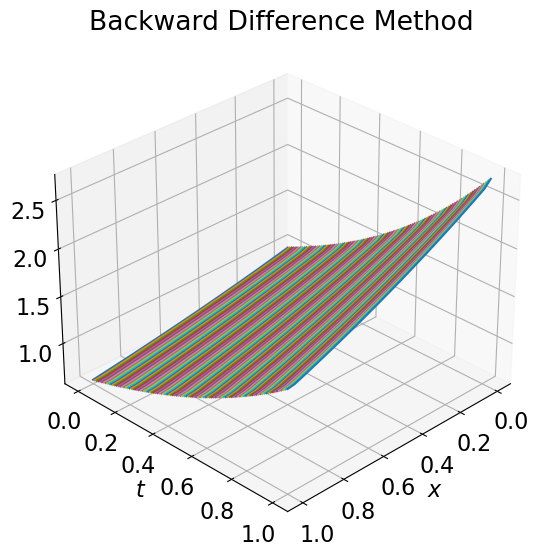

In [23]:
# Plotting
fig, ax = plt.subplots(1,1, figsize=(6.5, 6.5), subplot_kw={'projection':'3d'})

for j in range(K+1):
    ax.plot(x, t[j]*np.ones(N+2), w[:, j])

# Change the angle of projection

ax.set_xlabel('$x$')
ax.set_ylabel('$t$')

ax.view_init(elev=30, azim=45)

plt.title("Backward Difference Method")
plt.show()

### Solution

The true solution to the PDE is $u(x,t) = e^{t-x/2}$. We'll now calculate the error of the numerical solution. To measure error, we'll use the forward effort formula with the vector infinity norm, and plot to show the convergence of the numerical solution to the true solution.

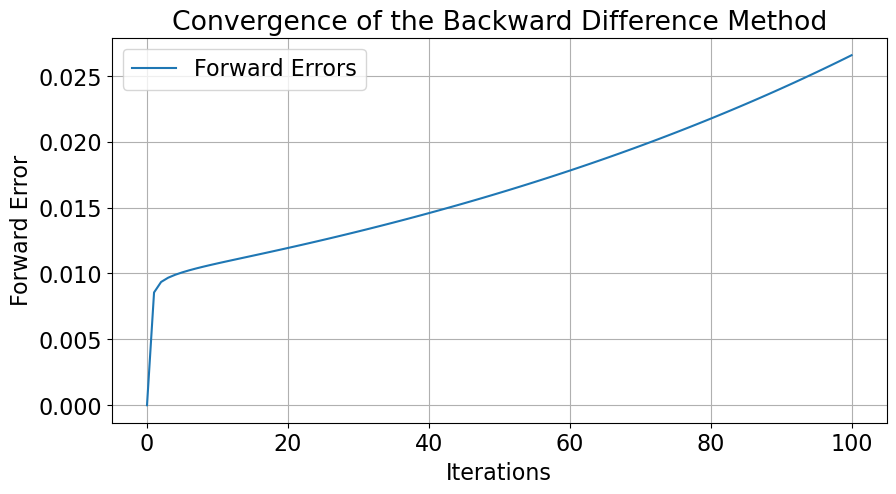

In [24]:
# true solution
u = lambda x, t: np.exp(t - (0.5 * x))
u = u(x.reshape(-1,1), t)

# calculating the error
# print(np.linalg.norm(w - u, np.inf)) - matrix infinity norm
errors = [] # list of errors

for j in range(K+1):
    r = u[:, j] - w[:, j] # forward error 
    #errors.append(r)
    norm = np.linalg.norm(r, np.inf)
    errors.append(norm)

# Plotting the errors
plt.figure(figsize=(10,5))
plt.plot(errors, label = 'Forward Errors')
plt.xlabel('Iterations')
plt.ylabel('Forward Error')
plt.title('Convergence of the Backward Difference Method')
plt.legend()
plt.grid(True)
plt.show()

The size of the truncation error is small we'll consider it's increasing behavior across iterations negligible. However, the graph of the errors does show the linear nature of the truncation error.

### Forward Difference Method

We'll now look at the convergence rate of the Forward Difference method on the same PDE. The forward difference method uses the forward difference for the 1st derivative in time instead of backward while still using the center-difference for the 2nd derivative in space:
$ u_t(x,t) = \frac{u(x,t+k)-u(x,t)}{k} + O(k) \\ \ \\
u_{xx}(x,t) = \frac{u(x+h,t)-2u(x,t)+u(x-h,t)}{h^2} + O(h^2) \\$
While the time approximation is different, the forward difference will also have a linear convergence rate dominated by the error of the time derivative. While the forward difference method isn't unconditionally stable, it requires $Dk/h^2 < 1/2$, we'll choose values of N and K to avoid an unstable numerical solution.

In [ ]:
# using forwards difference to find the solution
w = solve_heat_eq(ic, bc1, bc2, D, a, b, T, N, K, method='forward')

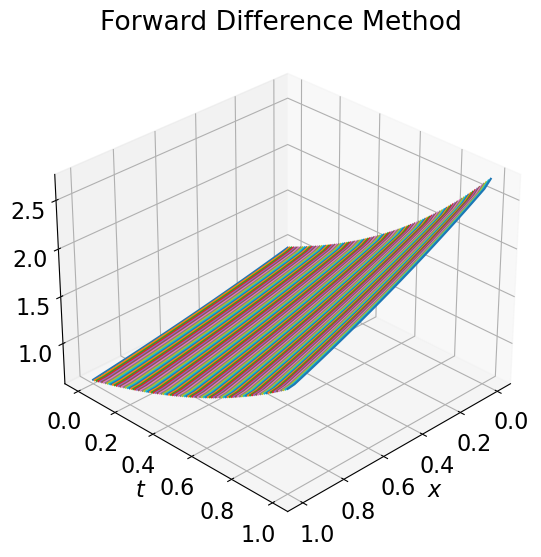

In [98]:
# Plotting
fig, ax = plt.subplots(1,1, figsize=(6.5, 6.5), subplot_kw={'projection':'3d'})

for j in range(K+1):
    ax.plot(x, t[j]*np.ones(N+2), w[:, j])

# Change the angle of projection

ax.set_xlabel('$x$')
ax.set_ylabel('$t$')

ax.view_init(elev=30, azim=45)

plt.title("Forward Difference Method")
plt.show()

To measure error, we will again use the forward error metric with the vector infinity norm.

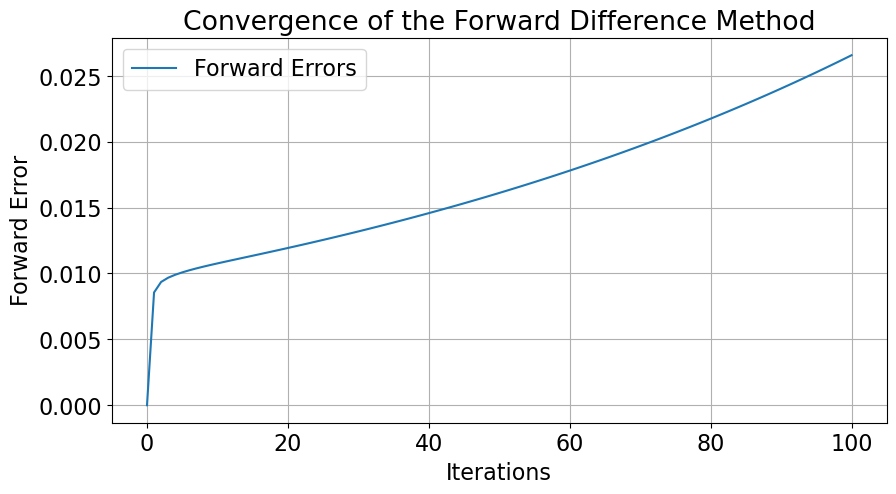

In [100]:
errors = [] # list of errors

for j in range(K+1):
    r = u[:, j] - w[:, j] # forward error 
    norm = np.linalg.norm(r, np.inf)
    errors.append(norm)

# Plotting the errors
plt.figure(figsize=(10,5))
plt.plot(errors, label = 'Forward Errors')
plt.xlabel('Iterations')
plt.ylabel('Forward Error')
plt.title('Convergence of the Forward Difference Method')
plt.legend()
plt.grid(True)
plt.show()

Much like the graph for the errors using the backward difference method, the errors can be considered negligible and the linear nature of the truncation errors appears in the graph.